![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Least-squares regression with MOSEK

Regression belongs to the basic toolbox of statistics, finance, machine learning, biology and many other disciplines that involves constructing approximate models of data. In this notebook we show how to quickly construct some and solve some standard regression models using the *Fusion* interface for Python.

Table of contents:

* least-squares (LSE, mean) regression
* regularization (ridge and lasso)
* robust regression with Huber loss function

Other related material:

* [Regression techniques for portfolio optimization using MOSEK](https://arxiv.org/abs/1310.3397)
* Another MOSEK notebook on regression under Lp-norms
* Future MOSEK notebooks will discuss LAD (least absolute deviation, $L_1$ or median) regression, quantile regression and mixed-integer piecewise-linear regression models.

A general linear regression model approximates the relation between a vector of $d$ independent variables (features)  $x=(x_1,\ldots,x_d)$ and a dependent variable $y$. (To allow for intercept we are often going to assume $x_1=1$). Suppose we have $n$ input vectors $x$ arranged in the rows of a matrix $\mathbf{X}\in\mathbb{R}^{n\times d}$ and $n$ corresponding observations $y$ arranged in a vector $\mathbf{y}\in\mathbb{R}^n$. The goal is to find a vector of weights $\mathbf{w}\in\mathbb{R}^{d}$ so that in some approximate sense we can write

$$\mathbf{y}\approx \mathbf{X}\mathbf{w}.$$

We call $\mathbf{r}=\mathbf{y}-\mathbf{X}\mathbf{w}$ the *residual* and we aim to minimize some penalty function $\phi(\mathbf{r})$.

In [1]:
from mosek.fusion import *
import numpy, sys
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Least-squares regression

In the simplest *unconstrained least squares problem* (LSE, mean regression) the penalty function is

$$\phi(\mathbf{r})=\|\mathbf{r}\|_2=\sqrt{\sum_{i=1}^n r_i^2}$$

and solving the least-squares regression problem is equivalent to the minimization problem

$$\mathrm{min}_{\mathbf{w}\in\mathbb{R}^d} \|\mathbf{y}-\mathbf{X}\mathbf{w}\|_2.$$

A conic formulation of this minimization problem is:

$$
\begin{array}{rl}
\mathrm{minimize} &            t \\
\mathrm{s.t.}     &            (t, \mathbf{y}-\mathbf{X}\mathbf{w}) \in \mathcal{Q} \\
                  &            \mathbf{w}\in\mathbb{R}^{d} \\
                  &            t\in\mathbb{R} 
\end{array}
$$
This formulation can be translated directly into a *Fusion* model:

In [2]:
# Least squares regresion
def lse(X, y):
    n, d = len(X), len(X[0])
    M = Model("LSE")
    
    # The regression coefficients
    w = M.variable("w", d)
    
    # The bound on the norm of the residual
    t = M.variable("t")
    r = Expr.sub(y, Expr.mul(X,w))
    # t \geq |r|_2
    M.constraint(Expr.vstack(t, r), Domain.inQCone())

    M.objective(ObjectiveSense.Minimize, t)
    return M

### Least squares example
As an example we use the basic model to estimate a simple polynomial regression problem with synthetic data points sampled from a degree $3$ planar curve with Gaussian error. 

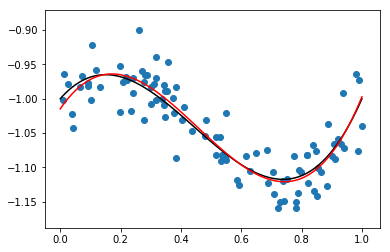

In [3]:
# Prepare the data
N = 100
sigma = 0.03
x = numpy.sort(numpy.random.uniform(0.0, 1.0, N))
def f(t):
    return 1.5*t**3 - 2*t**2 + 0.5*t - 1
y = f(x) + numpy.random.normal(0.0, sigma, N)
X = [[1,t,t**2,t**3] for t in x]

# Solve the model
M = lse(X, y)
M.solve()
w = M.getVariable("w").level()

# Plot the data points, original function (black) and regression function (red)
plt.scatter(x,y)
ticks = numpy.linspace(0, 1, 100)
plt.plot(ticks, f(ticks), 'k', color='black')
plt.plot(ticks, sum([w[i]*ticks**i for i in range(4)]), 'k', color='red')
plt.show()


Note that the unconstrained model leaves open numerous possibilities. It wold be just as easy to phrase the problem without intercepts, add additional linear or conic constraints on $\mathbf{w}$, compute various statistics of the solution and so on.

# Regularisation

Regularisation is a technique which helps stabilize computational results, which tend to be sensitive to small perturbations when the matrix $\mathbf{X}$ has nearly dependent columns. In machine learning regularisation is a major technique that  helps avoid overfitting. A general regularized least squares regression problem is usually written in the form

$$\mathrm{min}_{\mathbf{w}\in\mathbb{R}^d} \|\mathbf{y}-\mathbf{X}\mathbf{w}\|_2^2 + \lambda\phi'(T\mathbf{w})$$

where $T$ is a linear operator, for example $T\mathbf{w}=\mathbf{w}$ or $T\mathbf{w}=\mathbf{w}-\mathbf{w}_0$, $\phi'$ is an additional penalty function and $\lambda$ controls the tradeoff between regularisation and fit. The two main regularisation terms occurring in practice are:

* quadratic, also known as *ridge regression*, leading to the problem $$\mathrm{min}_{\mathbf{w}\in\mathbb{R}^d} \|\mathbf{y}-\mathbf{X}\mathbf{w}\|_2^2 + \lambda\|T\mathbf{w}\|_2^2$$
* linear, also known as *lasso (least absolute shrinkage and selection operator)*, leading to the problem $$\mathrm{min}_{\mathbf{w}\in\mathbb{R}^d} \|\mathbf{y}-\mathbf{X}\mathbf{w}\|_2^2 + \lambda\|T\mathbf{w}\|_1.$$ When $T=\mathrm{id}$ lasso regression tends to give preference to sparser solutions.
* *Elastic net*, a combination of quadratic and linear regularisation terms:
$$\mathrm{min}_{\mathbf{w}\in\mathbb{R}^d} \|\mathbf{y}-\mathbf{X}\mathbf{w}\|_2^2 + \lambda_1\|T_1\mathbf{w}\|_1 + \lambda_2\|T_2\mathbf{w}\|_2^2.$$

Below is the most general version formulated as a conic model, for simplicity with both $T_1$ and $T_2$ being the identity.

$$
\begin{array}{rl}
\mbox{minimize}      &   t + \lambda_1 p_{\mathrm{lasso}} + \lambda_2 p_{\mathrm{ridge}} \\
\mbox{subject to: residual} &  (0.5, t, \mathbf{y}-\mathbf{X}\mathbf{w}) \in \mathcal{Q}_{\mathrm{rot}} \\
                       &  \mathbf{w}\in\mathbb{R}^{d} \\
\mbox{lasso}    &  p_{\mathrm{lasso}} \geq \mathbf{p}_1+\cdots+\mathbf{p}_d \\
                       &  -\mathbf{p} \leq \mathbf{w} \leq \mathbf{p} \\
                       &  \mathbf{p} \in \mathbb{R}^d \\
\mbox{ridge}    &  (0.5, p_{\mathrm{ridge}}, \mathbf{w}) \in \mathcal{Q}_{\mathrm{rot}}
\end{array}
$$

Again, we have a straightforward translation to a *Fusion* model:

In [4]:
# Implement the lasso part of the constraints, and return the bounding variable
def lassoVar(M, w, d):
    p = M.variable("p", d)
    plasso = M.variable("plasso")
    
    # plasso >= sum(p_i)
    M.constraint(Expr.sub(plasso, Expr.sum(p)), Domain.greaterThan(0.0))
    
    # p_i = |w_i|
    M.constraint(Expr.add(p,w), Domain.greaterThan(0.0))
    M.constraint(Expr.sub(p,w), Domain.greaterThan(0.0))
    
    return plasso

# Implement the ridge part of the constraints, and return the bounding variable
def ridgeVar(M, w):
    pridge = M.variable("pridge")
    M.constraint(Expr.vstack(0.5, pridge, w), Domain.inRotatedQCone())
    return pridge
    
# Regularized least-squares regression
def lseReg(X, y, lambda1 = 0, lambda2 = 0):
    n, d = len(X), len(X[0])
    M = Model("LSE-REG")
    
    # The regression coefficients
    w = M.variable("w", d)
    
    # The bound on the norm of the residual
    t = M.variable("t")
    r = Expr.sub(y, Expr.mul(X,w))
    # t \geq |r|_2^2
    M.constraint(Expr.vstack(0.5, t, r), Domain.inRotatedQCone())
    
    # The objective, add regularization terms as required
    objExpr = t.asExpr()
    if lambda1 != 0: objExpr = Expr.add(objExpr, Expr.mul(lambda1, lassoVar(M,w,d)))
    if lambda2 != 0: objExpr = Expr.add(objExpr, Expr.mul(lambda2, ridgeVar(M,w)))
    M.objective(ObjectiveSense.Minimize, objExpr)
    return M

### Regularized least squares example
We consider the same dataset we had previously, but this time we try to fit a polynomial of very high degree. This will lead to overfitting, which can then be reduced by varying the regularization parameters $\lambda$.

Sparsity report:
lambda1  nonzeros in w

0.1      4 
0.01     4 
0.001    6 
0.0001   10
1e-05    8 


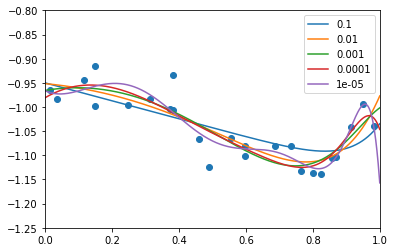

In [5]:
# Prepare the data
N = 25
degree = 15
sigma = 0.03
x = numpy.sort(numpy.random.uniform(0.0, 1.0, N))
def f(t):
    return 1.5*t**3 - 2*t**2 + 0.5*t - 1
y = f(x) + numpy.random.normal(0.0, sigma, N)
X = [[t**i for i in range(degree)] for t in x]

# Solve a number of lasso-regularized models
print( "Sparsity report:\nlambda1  nonzeros in w\n")
plt.axis([0.0, 1.0, -1.25, -0.80])
plt.scatter(x,y)
ticks = numpy.linspace(0.0, 1.0, 10000)
lambdas = [10**(-i) for i in range(1,6)]

for lambda1 in lambdas:
    M = lseReg(X, y, lambda1, 0)
    M.solve()
    w = M.getVariable("w").level()
    print("{0: <8} {1: <2}".format(lambda1, sum([0 if abs(val)<1e-5 else 1 for val in w])))

    # Plot the data points and regression function
    plt.plot(ticks, sum([w[i]*ticks**i for i in range(degree)]))

plt.legend(lambdas, loc='upper right')
plt.show()    


# Robust regression with Huber loss function

The penalty function $\phi(x)=x^2$ grows quite rapidly for large values of $x$, making the least-squares approximation overly sensitive to outliers. One solution to this issue in the realm of convex optimization is to replace it with the penalty defined as:
$$
\phi_{\mathrm{Huber}}(x) = 
\begin{cases}
x^2       &  |x|\leq M, \\
M(2|x|-M) &  |x|\geq M,
\end{cases}
$$
for some value of $M$. This *Huber loss function* agrees with the quadratic loss for small values of $x$ (small residuals) and otherwise it is the slowest-growing function preserving that property while remaining convex. Thus it assignes much lower loss to distant outliers than pure quadratic regression, maing it more robust. The *robust regression with Huber loss function* is now the problem

$$\mathrm{min}_{\mathbf{w}\in\mathbb{R}^d} \phi_{\mathrm{Huber}}(\mathbf{y}-\mathbf{X}\mathbf{w}).$$

It is left as an exercise to prove that an equivalent formulation of this optimization problem is

$$
\begin{array}{rl}
\mathrm{minimize} &            \|\mathbf{u}\|_2^2+2M\|\mathbf{v}\|_1 \\
\mathrm{s.t.}     &            -(\mathbf{u}+\mathbf{v})\leq \mathbf{y}-\mathbf{X}\mathbf{w} \leq \mathbf{u}+\mathbf{v}\\
                  &            0\leq \mathbf{u}\leq M\\
                  &            0\leq \mathbf{v} \\
                  &            \mathbf{u}, \mathbf{v}\in \mathbb{R}^n, \mathbf{w}\in\mathbb{R}^d
\end{array}
$$

We proceed directly to a *Fusion* implementation:

In [6]:
# Robust regression with Huber loss function
def huber(X, y, MConst):
    n, d = len(X), len(X[0])
    M = Model("LSE-HUBER")
    
    # The regression coefficients and other variables
    w = M.variable("w", d)
    u = M.variable(n, Domain.inRange(0.0, MConst))
    v = M.variable(n, Domain.greaterThan(0.0))
    
    # The residual and bounds on its absolute value (coordinatewise)
    r = Expr.sub(y, Expr.mul(X,w))
    ab= Expr.add(u,v)
    M.constraint(Expr.add(ab,r), Domain.greaterThan(0.0))
    M.constraint(Expr.sub(ab,r), Domain.greaterThan(0.0))
    
    # t >= |u|_2^2 and the objective
    t = M.variable()
    M.constraint(Expr.vstack(0.5, t, u), Domain.inRotatedQCone())
    M.objective(ObjectiveSense.Minimize, Expr.add(t, Expr.mul(2*MConst, Expr.sum(v))))
    return M

### Huber regression example

We demonstrate the Huber regression compared to standard least-squares regression on an example with distant outliers.

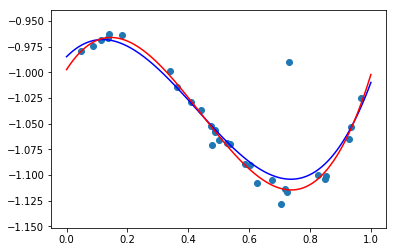

In [7]:
# Prepare the data
N = 30
sigma = 0.005
x = numpy.sort(numpy.random.uniform(0.0, 1.0, N))
def f(t):
    return 1.5*t**3 - 2*t**2 + 0.5*t - 1
y = f(x) + numpy.random.normal(0.0, sigma, N)
# Append an outlier
x = numpy.append(x, 0.73)
y = numpy.append(y, -0.99)
X = [[t**i for i in range(4)] for t in x]

# Solve the models
LSE, HUB = lse(X, y), huber(X, y, 5*sigma)
LSE.solve()
HUB.solve()
wLSE = LSE.getVariable("w").level()
wHUB = HUB.getVariable("w").level()

# Plot the data points, LSE approximation (blue) and Huber approximation (red)
plt.scatter(x,y)
ticks = numpy.linspace(0, 1, 100)
plt.plot(ticks, sum([wLSE[i]*ticks**i for i in range(4)]), 'k', color='blue')
plt.plot(ticks, sum([wHUB[i]*ticks**i for i in range(4)]), 'k', color='red')
plt.show()

The red curve is clearly less affected by the outlier.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 